In [2]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [3]:
pgroup='p20537'
runnumber = 198
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0198


'/sf/alvra/data/p20537/raw/run0198-YAG_scan_pink_T0p01/meta/scan.json'

In [2]:
fc = FileChooser('/sf/alvra/data/p20537/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [ ]:
jsonfile = copy.copy(fc.selected)
jsonfile

In [4]:
TT = TT_PSEN126

quantile_band = 0.8

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)

########################################
#YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
#YAG_scan_one_TT_bs(json_file, TT, channel_delay_motor, timezero_mm, quantile, filterTime=2000, filterAmp=0):
########################################
flag = False

try:
    Timezero_mm = get_timezero_NBS(fc.selected)
    flag = True
except:
    Timezero_mm = Timezero_mm

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
    
Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

    #Delays_corr -= Delay_fs

#pp_uncorrected = Pump_probe[:,0]
#err_pp_low = Pump_probe[:,1]
#err_pp_high = Pump_probe[:,2]

Processing: run0198-YAG_scan_pink_T0p01
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               500 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 500 / 501 -> 0% loss
complete channels: 9 / 10 -> 10% incomplete

---------------------

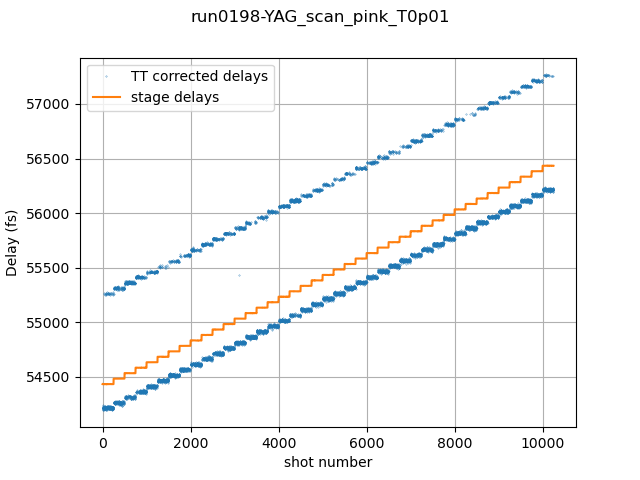

In [5]:
plt.figure()
plt.suptitle(jsonfile.split('/')[-3])
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Re-bin the data with chosen binsize

In [7]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)

(10247,) (10247,)


## Choose fit function

In [8]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [9]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
#print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

(55417.745899702175, 0.44466472720853834, 10.233644859813085, -0.00198428303176269)
Position t0 = 198.31688 mm
Width = 99.50808 fs


## Plot

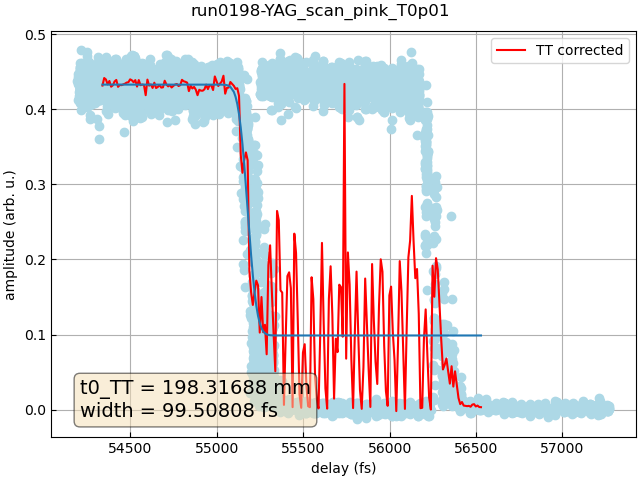

Position t0_raw = 190.04582 mm
Position t0_TT = 198.3168838769759 mm


In [11]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3] )#+ " mono")

plt.tick_params(direction='in')

plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

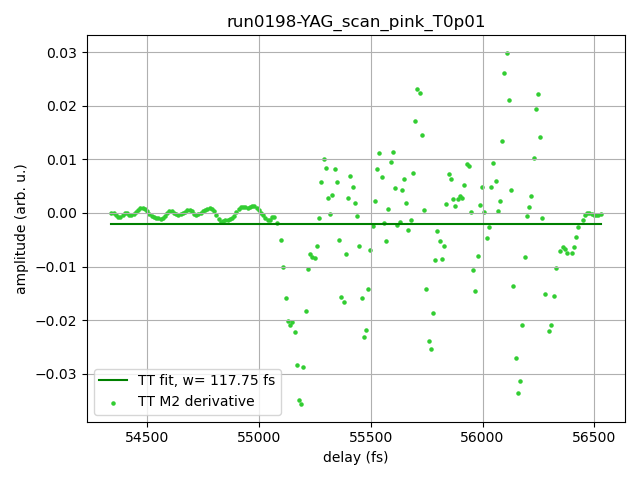

In [12]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])

plt.figure()
plt.title(jsonfile.split('/')[-3])
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()


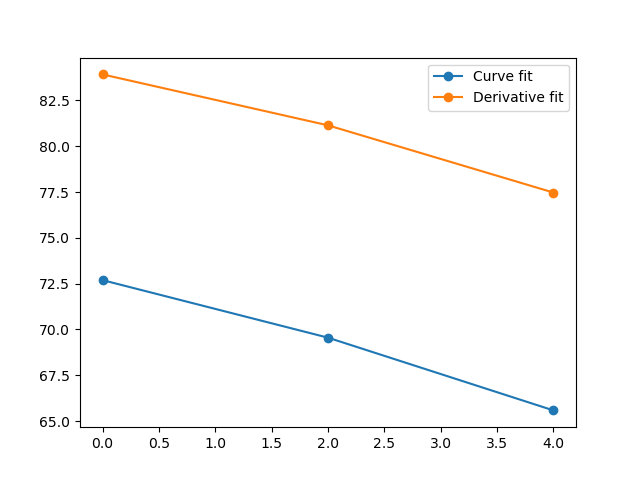

In [213]:
compressor_steps = [0, 2, 4]
width = [72.69, 69.55, 65.58]
width_der = [83.92, 81.14, 77.47]

plt.figure()
plt.plot(compressor_steps, width, marker = 'o', label = 'Curve fit')
plt.plot(compressor_steps, width_der, marker = 'o', label = 'Derivative fit')
plt.legend()
plt.show()

# Loop over several runs

In [13]:
datafiles = []
#for file in glob.glob('/gpfs/photonics/swissfel/raw/alvra-staff/p19776/run*YAG_pink_air_loop*/meta/scan.json'):
for file in glob.glob('/sf/alvra/data/p19776/raw/run*YAG_pink_air_loop*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch =  datafiles[:5]
patch

['/sf/alvra/data/p19776/raw/run0438-YAG_pink_air_loop_001/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0439-YAG_pink_air_loop_002/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0440-YAG_pink_air_loop_003/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0441-YAG_pink_air_loop_004/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0442-YAG_pink_air_loop_005/meta/scan.json']

In [14]:
TT = TT_PSEN126

quantile_band = 0.5
binsize = 10 # in fs

channel_delay_motor = channel_delay_topas

Timezero_mm = 108.72812 

flag = False

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_scan =[]
width_fs_scan = []
width_fs_scan_der = []

timestamps_npy = []
timestamps_hms = []

for num, json_file in enumerate(patch):
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed:
    #fit.p0 =[191.06, 0.04, 80, 0.0, 500]#, 3e-5, 0.035]

    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    
    pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
    parameters_der,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)
    width_fs_scan_der.append(np.abs(parameters_der[2]*2.355))
    
    #ax.scatter(Delay_fs_TT, pp_TT_derivative, color=colors[num], s = 5)
    #ax.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_der), color=colors[num],\
    #        label = '{:.2f} fs'.format(np.abs(parameters_der[2]*2.355)))
    
    timestamps_npy.append(timestamp(json_file))
    timestamps_hms.append(timestamp_hms(json_file))

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))


Processing: run0442-YAG_pink_air_loop_005
Step 81 of 81: Processing acq0081

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 10 / 10 -> 0% incomplete

-------------------

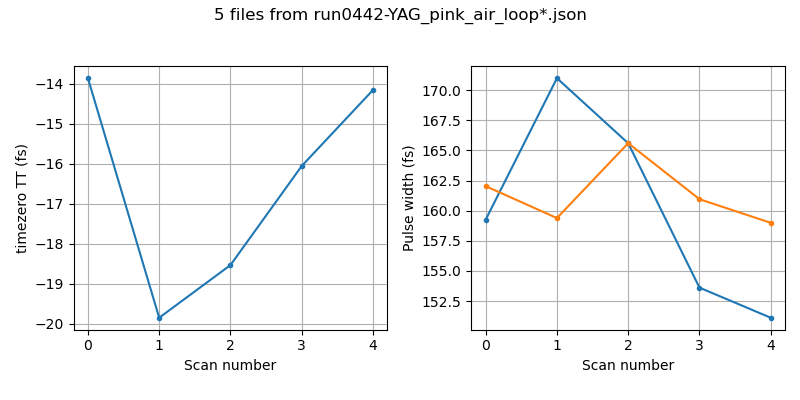

In [15]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))


plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan_der, marker='.', label = 'Derivative fit')

plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

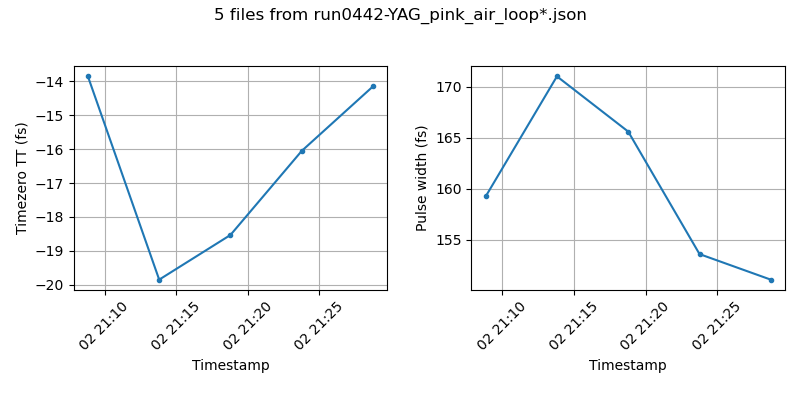

In [16]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
# plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(121)
plt.plot(timestamps_npy, t0_fs_scan, marker='.')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.subplot(122)
plt.plot(timestamps_npy, width_fs_scan, marker='.')
plt.xlabel('Timestamp')
plt.ylabel('Pulse width (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
TT = TT_PSEN126

target = 'babyYAG'
px2fs = 1.8692375 

arrTimes, arrTimesAmp, arrTimes_scan, arrTimesAmp_scan, peaktraces = \
TT_statistics_scan(fc.selected, TT, target, px2fs)

Processing: run0154
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)


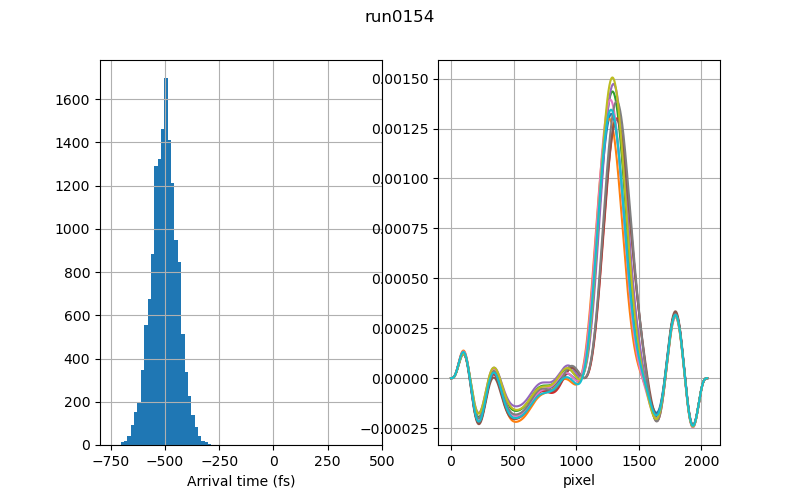

Statistics on all (14543,) shots of the scan
Offset compared to pixel 1024 is -502.3513764672008 fs
Jitter, i.e. width (std) of the histogram 59.857580568151434 fs
--------------------------------------------------------------
Statistics on (250,) shots of the last step of the scan
Offset compared to pixel 1024 is -504.67169415 fs
Jitter, i.e. width (std) of the histogram 44.93531310824471 fs


In [7]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(arrTimes_scan, bins=30)
plt.grid()
plt.xlim(-800,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(122)
plt.suptitle (fc.selected.split('/')[-3])
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_scan)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes)))
